In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Para ver que es cada score ----- > https://database.coffeeinstitute.org/coffee/976032/grade

#### Descargar el conjunto de CoffeeRatings.csv1, para realizar el trabajo práctico. Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de datos, etc.)

En el archivo csv estan separados por ";" asi que en los parametros del metodo read_csv de pandas ajustamos esto para una lectura correcta

In [4]:
dataframe = pd.read_csv('CoffeeRatings.csv', delimiter=';')
dataframe.head()


,Scores_Aroma,Scores_Flavor,Scores_Aftertaste,Scores_Acidity,Scores_Body,Scores_Balance,Scores_Uniformity,Scores_Sweetness,Scores_Moisture,Scores_Total,Color
0,85,85,80,80,80,80,100,100,12,8692,Green
1,85,817,80,775,80,80,100,100,12,8642,Green
2,833,80,80,80,775,80,100,100,11,8608,Blue-Green
3,80,80,80,767,775,80,100,100,11,8542,Blue-Green
4,80,792,775,775,80,775,100,100,11,8492,Green


No tenemos nulos

In [5]:
dataframe.isnull().any()

Scores_Aroma         False
Scores_Flavor        False
Scores_Aftertaste    False
Scores_Acidity       False
Scores_Body          False
Scores_Balance       False
Scores_Uniformity    False
Scores_Sweetness     False
Scores_Moisture      False
Scores_Total         False
Color                False
dtype: bool

In [6]:
dataframe.duplicated().sum()

0

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Scores_Aroma       835 non-null    int64 
 1   Scores_Flavor      835 non-null    int64 
 2   Scores_Aftertaste  835 non-null    int64 
 3   Scores_Acidity     835 non-null    int64 
 4   Scores_Body        835 non-null    int64 
 5   Scores_Balance     835 non-null    int64 
 6   Scores_Uniformity  835 non-null    int64 
 7   Scores_Sweetness   835 non-null    int64 
 8   Scores_Moisture    835 non-null    int64 
 9   Scores_Total       835 non-null    int64 
 10  Color              835 non-null    object
dtypes: int64(10), object(1)
memory usage: 71.9+ KB


Antes de ver las variables numericas observamos los colores, vemos que los granos verdes son casi el 82% de los datos
Este desbalance puede causar algun error en la clasificacion

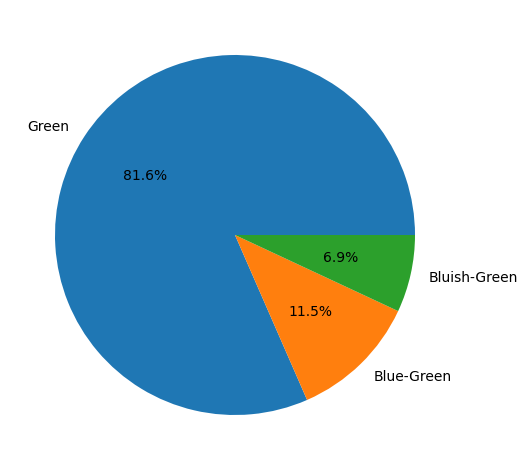

In [8]:
fig, ax = plt.subplots()
ax.pie(dataframe['Color'].value_counts(), labels=dataframe['Color'].unique(), autopct='%1.1f%%')
plt.tight_layout()
plt.show()

# Variables numericas

In [9]:
dataframe.describe()

,Scores_Aroma,Scores_Flavor,Scores_Aftertaste,Scores_Acidity,Scores_Body,Scores_Balance,Scores_Uniformity,Scores_Sweetness,Scores_Moisture,Scores_Total
count,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000,835.000000
mean,623.726946,615.576048,611.677844,617.116168,610.330539,611.276647,191.758084,157.644311,8.231138,6675.440719
std,273.720152,274.245606,263.865747,274.480062,276.366482,276.300203,257.583828,203.439529,5.130245,3007.519639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,717.000000,708.000000,683.000000,717.000000,708.000000,692.000000,100.000000,100.000000,1.000000,7792.000000
50%,758.000000,742.000000,733.000000,742.000000,742.000000,742.000000,100.000000,100.000000,11.000000,8183.000000
75%,775.000000,767.000000,758.000000,767.000000,767.000000,767.000000,100.000000,100.000000,12.000000,8325.000000
max,875.000000,883.000000,867.000000,875.000000,842.000000,858.000000,933.000000,933.000000,17.000000,9058.000000


- La mayoria de datos oscilan entre 0 a 900 (salvo en las columnas de Moisture y Total)
- Podemos ver que en todas las columnas la mediana y la media no estan cerca

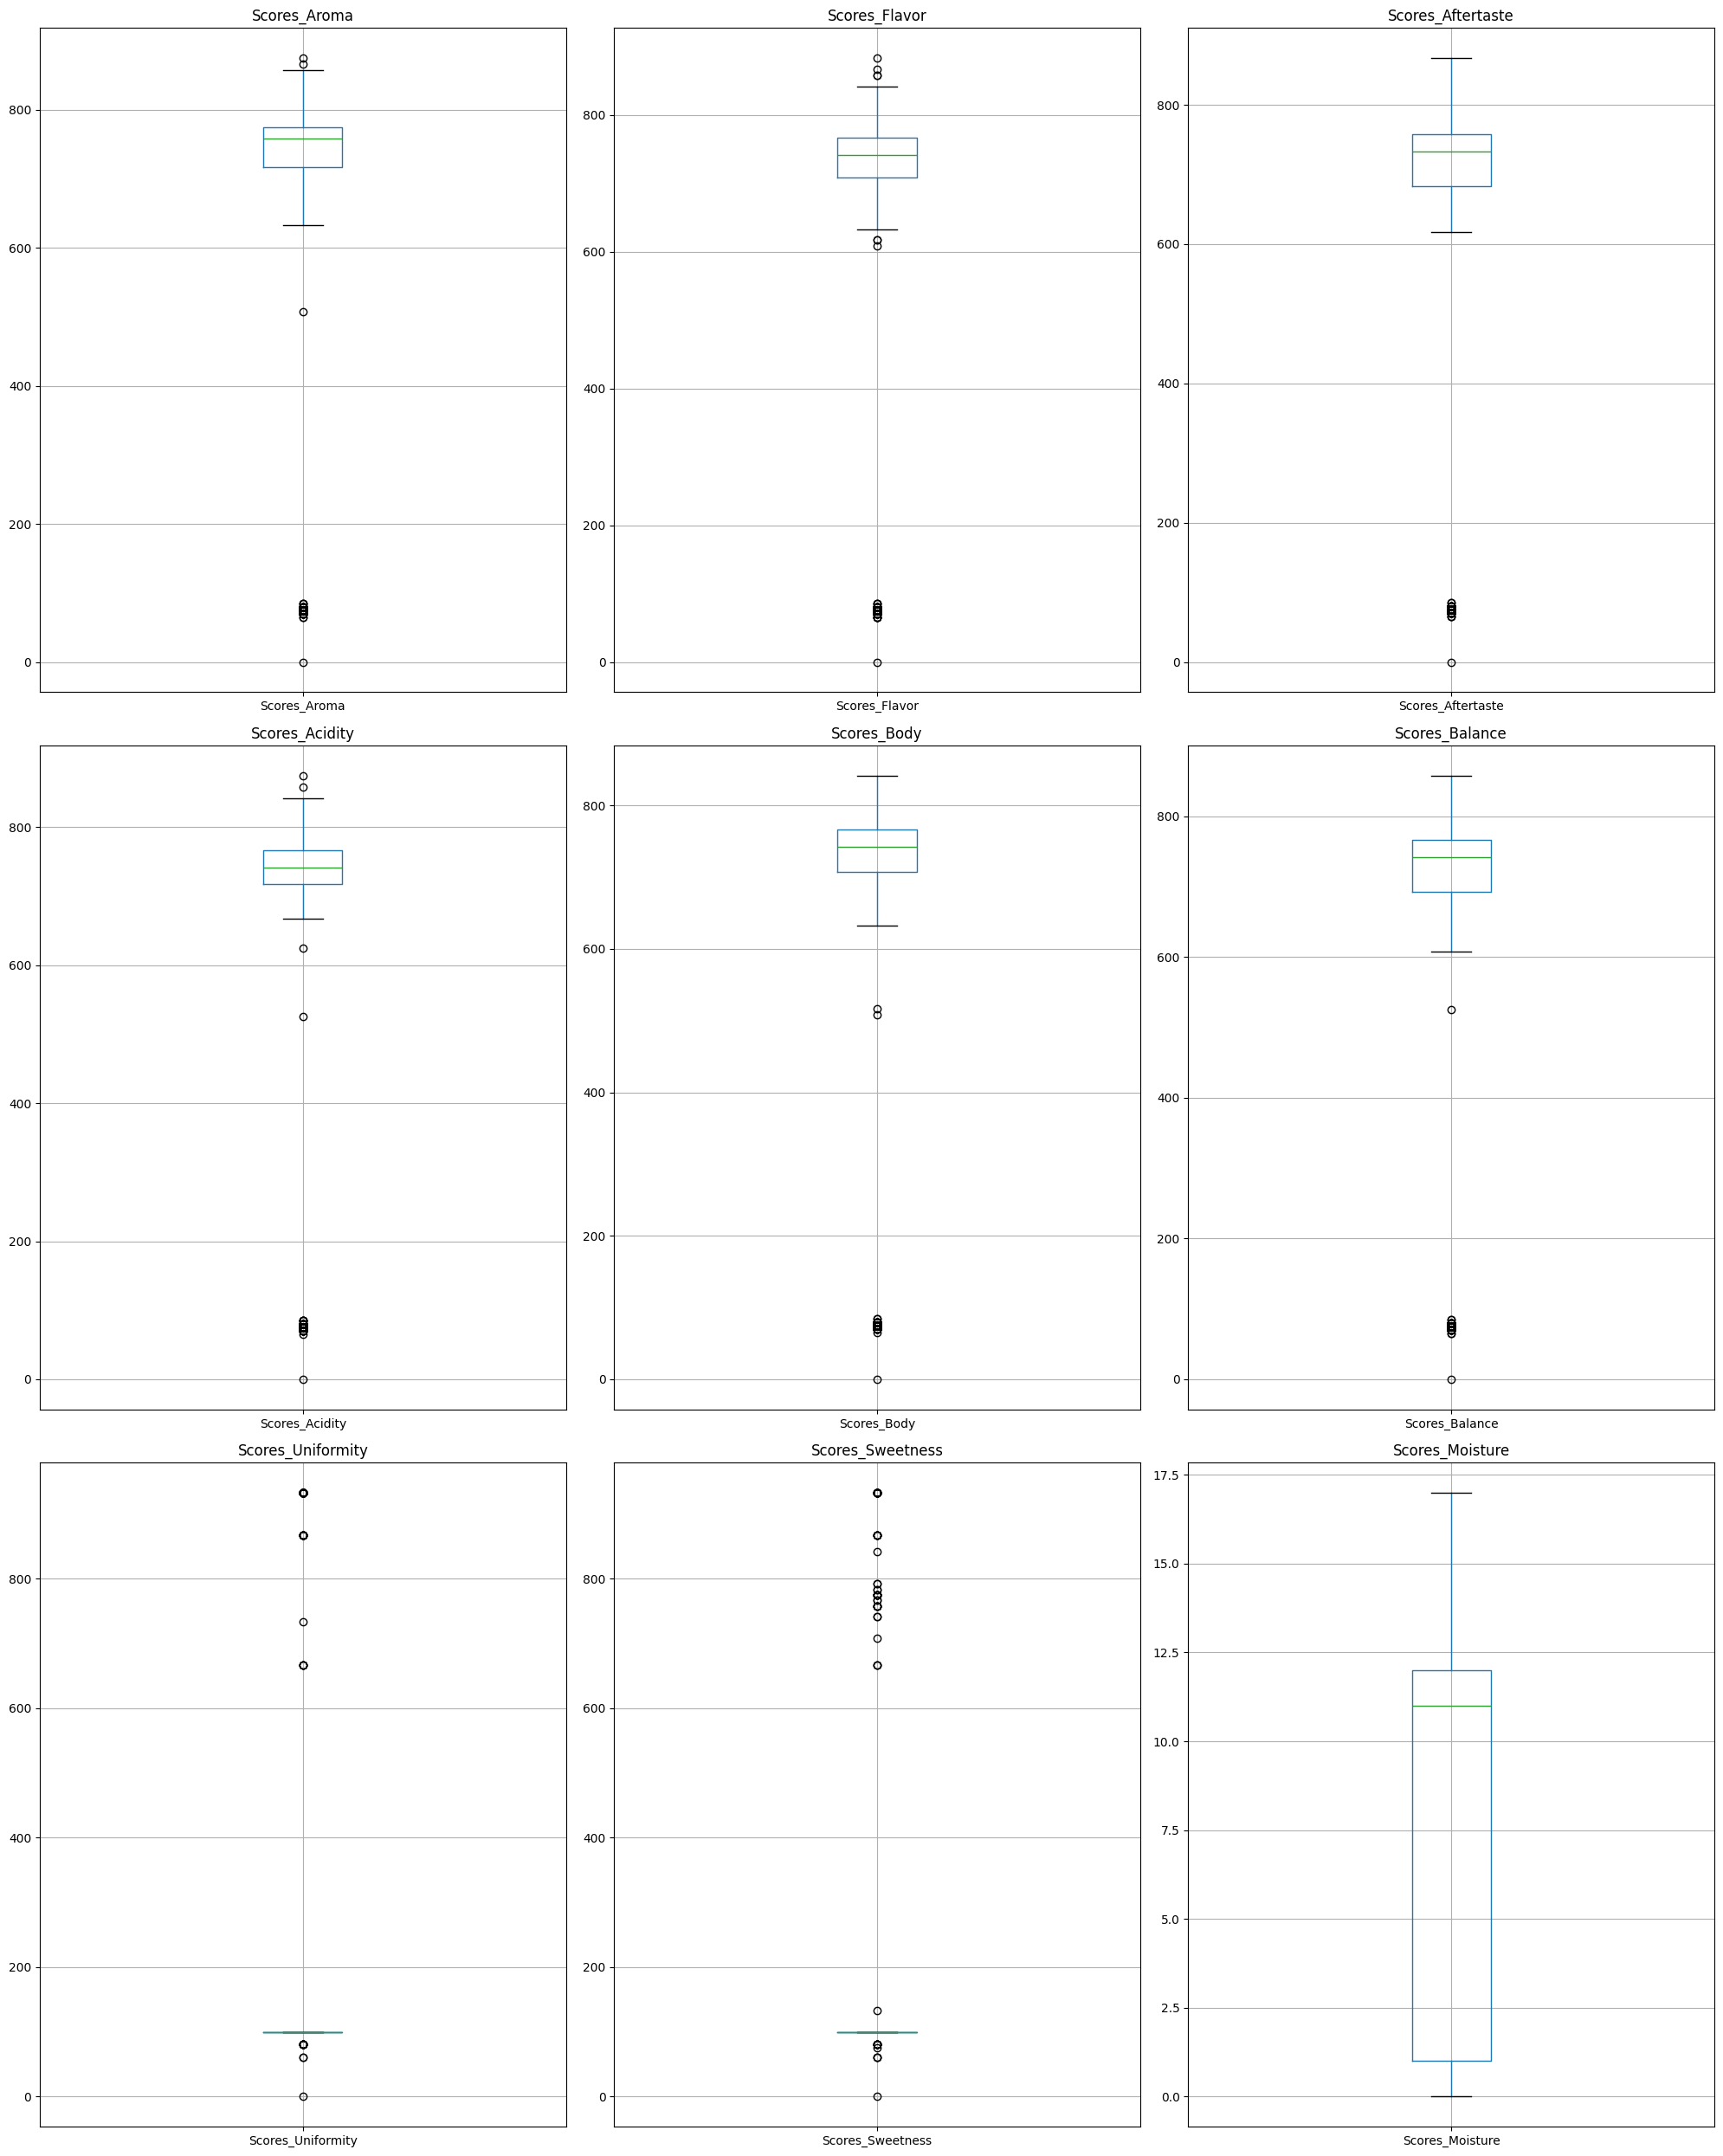

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
axes = axes.flatten() 
for i, col in enumerate(dataframe.columns[:9]):
    dataframe.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Todas las variables salvo Scores_moisture presentan valores atipicos

In [11]:
numeric_columns = [column for column in dataframe.columns if column != 'Color']

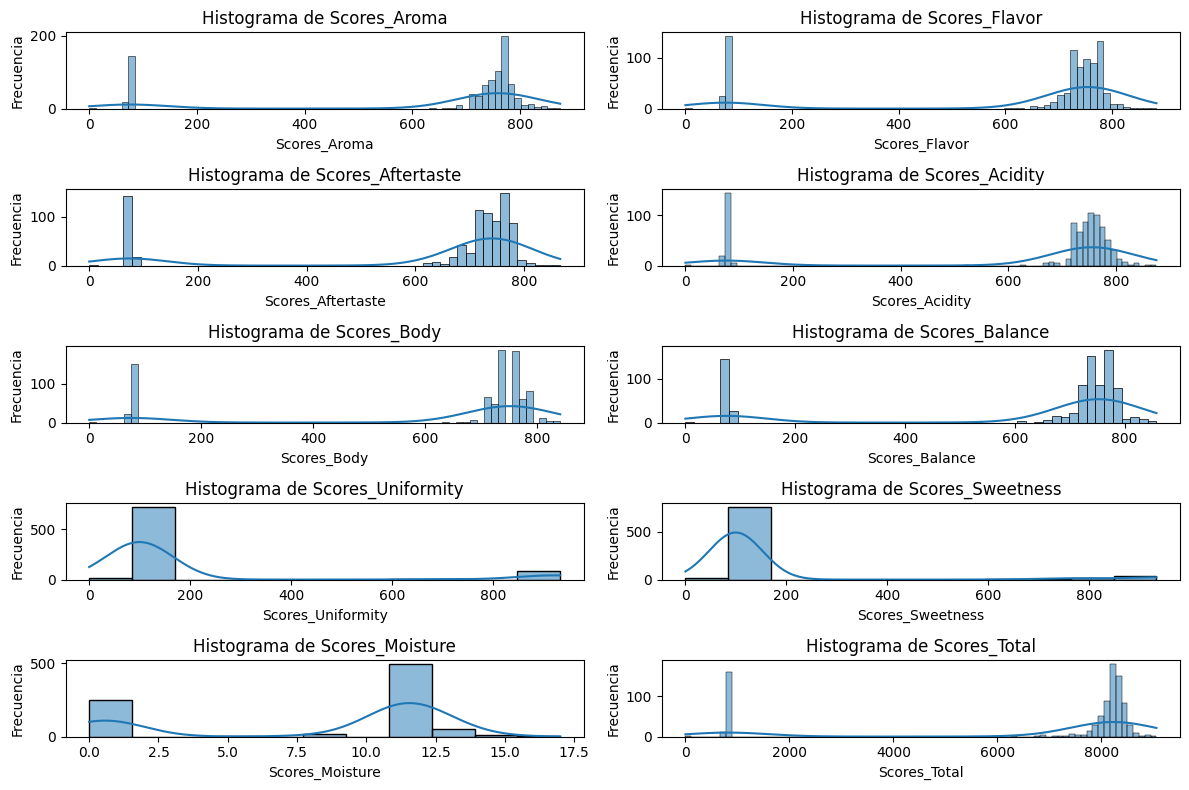

In [12]:
plt.figure(figsize=(12, 8))

for i, columna in enumerate(numeric_columns):
    plt.subplot((len(numeric_columns) + 1)//2, 2, i+1)
    sns.histplot(dataframe[columna], kde=True) 
    plt.title(f'Histograma de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')


plt.tight_layout()
plt.show()

- Todas las variables numericas presentan una distribucion binomial, esto nos ayuda a explicar por que todas las variables tenian valores atipicos en los graficos de caja

In [13]:
numeric_columns
for i in numeric_columns:
    print(dataframe.loc[(dataframe[i] >= 150) & (dataframe[i] <= 500)])

Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Total, Color]
Index: []
Empty DataFrame
Columns: [Scores_Aroma, Scores_Flavor, Scores_Aftertaste, Scores_Acidity, Scores_Body, Scores_Balance, Scores_Uniformity, Scores_Sweetness, Scores_Moisture, Scores_Tota

- Vemos que de 200 a 500 en las variables numericas no hay valores, esto refleja sobre la forma en la que se evaluan los granos, quizas mas que un score numerico podria ser bueno/malo

# Normalizar el dataset para modelado

In [14]:
from sklearn.model_selection import train_test_split


In [15]:
# X son las variables independientes y 'Color' es la variable dependiente
X = dataframe.drop('Color', axis=1)
y = dataframe['Color']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y ajustar el StandardScaler
scaler = StandardScaler()
X_train_escalado = scaler.fit_transform(X_train)
X_test_escalado = scaler.transform(X_test)

# Grid SEARCH PARA LOS PARAMETROS SOLICITADOS DE LAS SVM

In [16]:
svm_params = SVC(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],    
}


grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'C': 0.1, 'kernel': 'linear'}


In [17]:
# Definición de un modelo clasificador de Random Forest
svm_params = SVC(random_state=42)

# Definir los hiperparámetros a ajustar y sus posibles valores
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],

}

# Configurar la búsqueda grid con validación cruzada (cross-validation)
grid_search = GridSearchCV(estimator=svm_params, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')

# Realizar la búsqueda grid en el conjunto de entrenamiento
grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}


# SVM Con Kernel lineal y analizando el parametro costo SIN CROSSVALIDATION


In [18]:
svm_linear_nocross = SVC(kernel='linear', C=0.1, random_state=42)

In [19]:
svm_linear_nocross.fit(X_train_escalado, y_train)

SVC(C=0.1, kernel='linear', random_state=42)

In [20]:
# Predicciones
y_pred_linear = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.84%


In [21]:
dataframe['Color'].value_counts()

Color
Green           681
Bluish-Green     96
Blue-Green       58
Name: count, dtype: int64

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



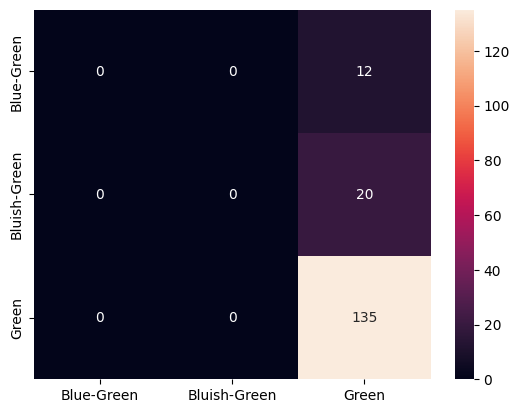

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_linear))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_linear))

# Ahora kernel lineal con cross validation

In [23]:
svm = SVC(kernel='linear', C=0.1)

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

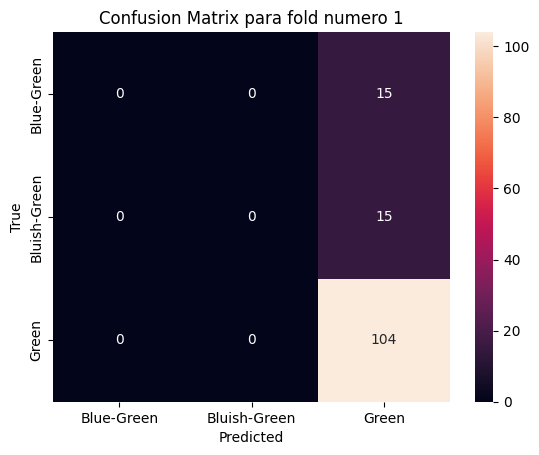

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        15
Bluish-Green       0.00      0.00      0.00        15
       Green       0.78      1.00      0.87       104

    accuracy                           0.78       134
   macro avg       0.26      0.33      0.29       134
weighted avg       0.60      0.78      0.68       134



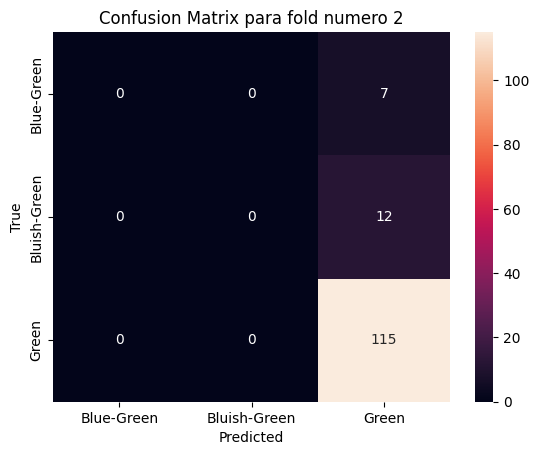

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         7
Bluish-Green       0.00      0.00      0.00        12
       Green       0.86      1.00      0.92       115

    accuracy                           0.86       134
   macro avg       0.29      0.33      0.31       134
weighted avg       0.74      0.86      0.79       134



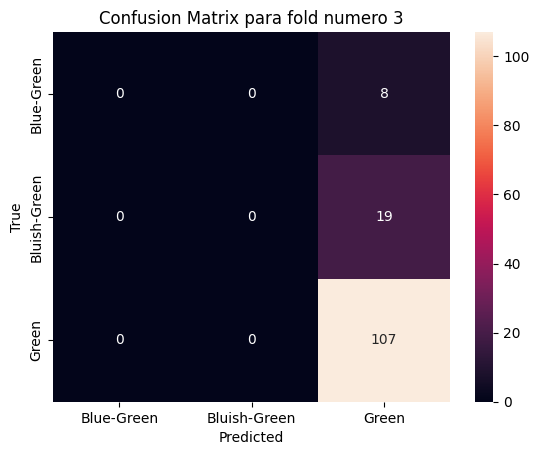

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        19
       Green       0.80      1.00      0.89       107

    accuracy                           0.80       134
   macro avg       0.27      0.33      0.30       134
weighted avg       0.64      0.80      0.71       134



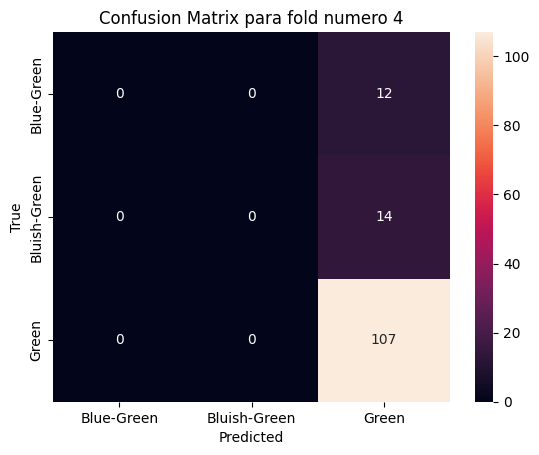

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        14
       Green       0.80      1.00      0.89       107

    accuracy                           0.80       133
   macro avg       0.27      0.33      0.30       133
weighted avg       0.65      0.80      0.72       133



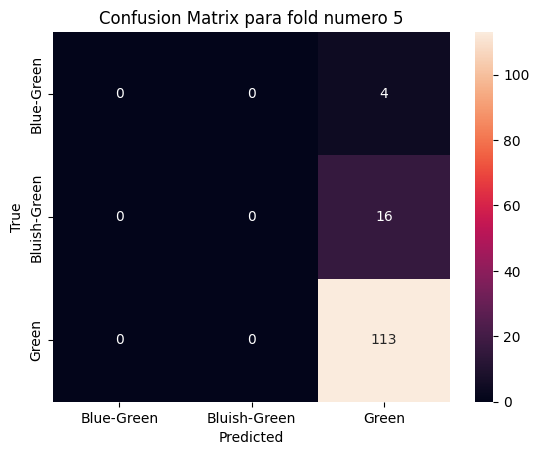

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         4
Bluish-Green       0.00      0.00      0.00        16
       Green       0.85      1.00      0.92       113

    accuracy                           0.85       133
   macro avg       0.28      0.33      0.31       133
weighted avg       0.72      0.85      0.78       133



In [25]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))

    fold += 1

- El modelo generaliza igual sobre el conjunto de test
- ambos modelos (con y sin Cross validation) tienen recall de 1 en la clase green
- Todos los datos de green se predicen correctamente
- Se predicen como green algunos otros valores, pero como la cantidad de green es tan alta la accuracy es de 85% lo cual es alta


# EJ 3 sin cv


In [26]:
svm_gauss_nocross = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001)

In [27]:
svm_gauss_nocross.fit(X_train_escalado, y_train)

SVC(C=0.1, gamma=0.001, random_state=42)

In [28]:
# Predicciones
y_pred_gauss = svm_linear_nocross.predict(X_test_escalado)

# Evaluación
accuracy = accuracy_score(y_test, y_pred_gauss)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.84%


In [29]:
dataframe['Color'].value_counts()

Color
Green           681
Bluish-Green     96
Blue-Green       58
Name: count, dtype: int64

              precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        20
       Green       0.81      1.00      0.89       135

    accuracy                           0.81       167
   macro avg       0.27      0.33      0.30       167
weighted avg       0.65      0.81      0.72       167



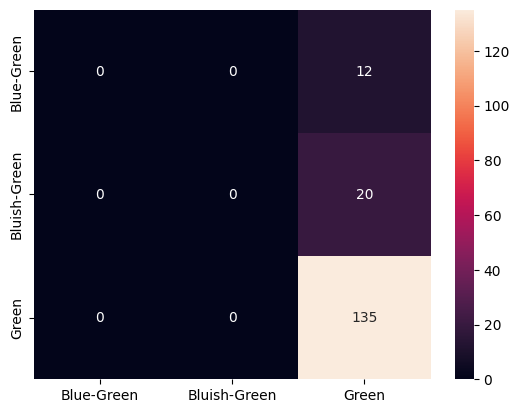

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cm = (confusion_matrix(y_test, y_pred_gauss))
a = ["Blue-Green", "Bluish-Green", "Green"]

sns.heatmap(cm, xticklabels = a, yticklabels = a,annot=True, fmt='g')

print(classification_report(y_test, y_pred_gauss))

# 4

In [33]:
svm_gaussiano = SVC(kernel='rbf', C=0.1, random_state=42, gamma=0.001)

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

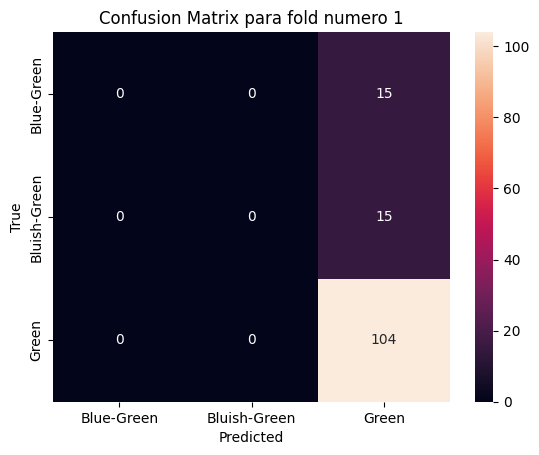

Classification Report para fold numero 1:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        15
Bluish-Green       0.00      0.00      0.00        15
       Green       0.78      1.00      0.87       104

    accuracy                           0.78       134
   macro avg       0.26      0.33      0.29       134
weighted avg       0.60      0.78      0.68       134



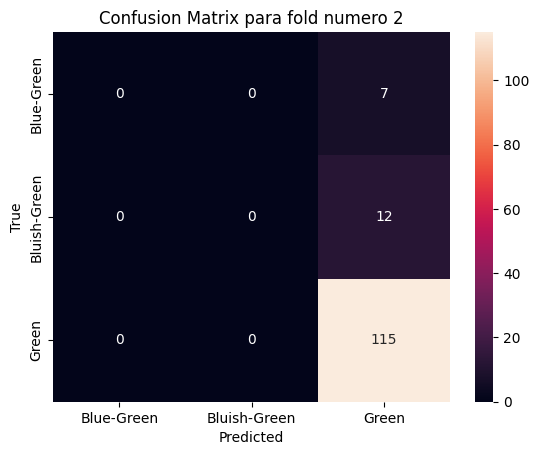

Classification Report para fold numero 2:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         7
Bluish-Green       0.00      0.00      0.00        12
       Green       0.86      1.00      0.92       115

    accuracy                           0.86       134
   macro avg       0.29      0.33      0.31       134
weighted avg       0.74      0.86      0.79       134



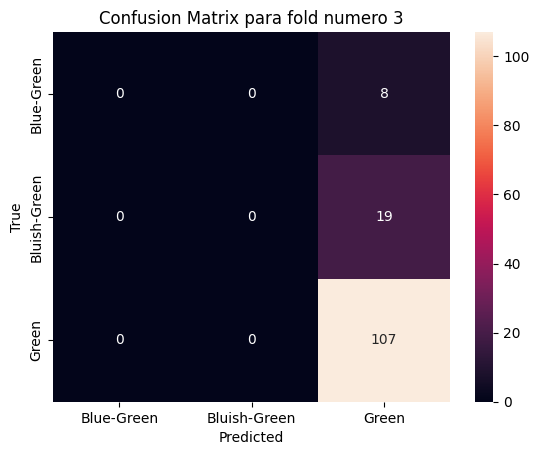

Classification Report para fold numero 3:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         8
Bluish-Green       0.00      0.00      0.00        19
       Green       0.80      1.00      0.89       107

    accuracy                           0.80       134
   macro avg       0.27      0.33      0.30       134
weighted avg       0.64      0.80      0.71       134



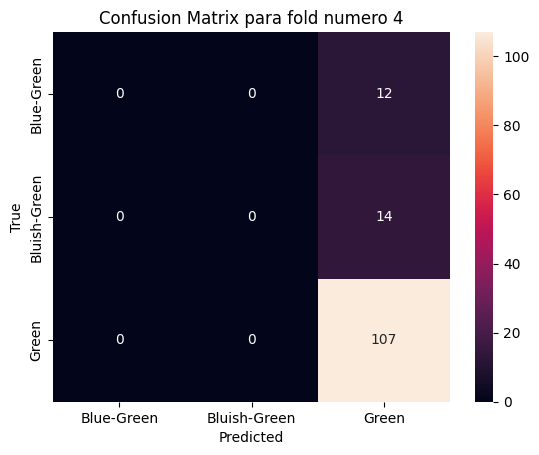

Classification Report para fold numero 4:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00        12
Bluish-Green       0.00      0.00      0.00        14
       Green       0.80      1.00      0.89       107

    accuracy                           0.80       133
   macro avg       0.27      0.33      0.30       133
weighted avg       0.65      0.80      0.72       133



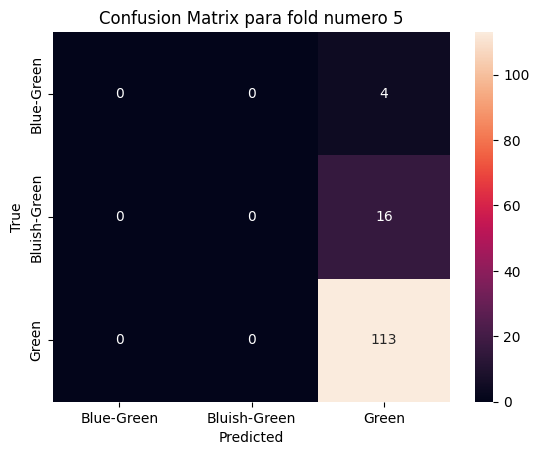

Classification Report para fold numero 5:
               precision    recall  f1-score   support

  Blue-Green       0.00      0.00      0.00         4
Bluish-Green       0.00      0.00      0.00        16
       Green       0.85      1.00      0.92       113

    accuracy                           0.85       133
   macro avg       0.28      0.33      0.31       133
weighted avg       0.72      0.85      0.78       133



In [35]:
fold = 1
for i, (train_index, val_index) in enumerate(kf.split(X_train_escalado)):
    
    #evitar el error out of index
    index_labels = y_train.index
    trainsc_df = pd.DataFrame(X_train_escalado, index=index_labels)


    X_train_fold, X_val_fold = trainsc_df.iloc[train_index], trainsc_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    svm_gaussiano.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = svm_gaussiano.predict(X_val_fold)

    # Compute confusion matrix and classification report
    cm = confusion_matrix(y_val_fold, y_pred_fold)
    # Matriz de confusion x cada fold
    a = ["Blue-Green", "Bluish-Green", "Green"]
    sns.heatmap(cm, xticklabels=a, yticklabels=a, annot=True, fmt='g')
    plt.title(f"Confusion Matrix para fold numero {fold}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print(f"Classification Report para fold numero {fold}:\n", classification_report(y_val_fold, y_pred_fold))



    fold += 1

# 5

In [36]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf_classifier = RandomForestClassifier(random_state=42)

# Definir los hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [30, 50],

}


grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring = ['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')


grid_search.fit(X_train_escalado, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print('Mejores hiperparámetros:', best_params)

Mejores hiperparámetros: {'max_depth': 30, 'n_estimators': 100}


Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 300, 'max_samples': 50, 'min_samples_leaf': 10, 'n_estimators': 50, 'random_state': 42}